PEDRO MARTINS MOREIRA NETO - pedromartins.cwb@gmail.com

#### Lab2: Impactos base de Aprendizagem

Para esse laboratório considere os seguintes classificadores:
 * KNN
 * Naïve Bayes
 * Linear Discriminant Analysis
 * Logistic Regression

Considere também as base de treinamento (20000 exemplos) e teste (58646 exemplos)

#### Tarefa
    1) Compare o desempenho desses classificadores em função da disponibilidade de base de treinamento. Alimente os classificadores com blocos de 1000 exemplos e plote num gráfico o desempenho na base de testes e analise em qual ponto o tamanho da base de treinamento deixa de ser relevante.

    2) Qual é o classificador que tem o melhor desempenho com poucos dados < 1000 exemplos.

    3) Qual é o classificador que tem melhor desempenho com todos os dados.

    4) Qual é o classificador é mais rápido para classificar os 58k exemplos de teste.

    5) O que vc pode dizer a respeito das matrizes de confusão. Os erros são os mesmos para todos os classificadores quando todos eles utlizam toda a base de teste?

### Importe das bibliotecas necessárias

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix 
from sklearn.datasets import load_svmlight_file
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

### Carregamento dos dados

In [3]:
X_train, y_train = load_svmlight_file('train.txt')
X_test, y_test = load_svmlight_file('test.txt')
size = X_train.shape
print("Training size", size)
print("Testing size", X_test.shape)

Training size (20000, 132)
Testing size (58646, 132)


### Definição da função Fit 
    Função que vai treinar, executar a função predict e retornar a matriz de confusão e score

In [4]:
def fit(X_train, y_train, X_test, y_test, clf):

    X_train_dense = X_train.toarray()
    clf.fit(X_train_dense, y_train)

    X_test_dense = X_test.toarray()
    y_pred = clf.predict(X_test_dense) 
    
    cm = confusion_matrix(y_test, y_pred)
    
    # mostra o resultado do classificador na base de teste
    return clf.score(X_test_dense, y_test), cm

## Execução do experimento

Compare o desempenho desses classificadores em função da disponibilidade de base de treinamento. 
Alimente os classificadores com blocos de 1000 exemplos

**Determinando o tamanho dos batchs**

De 100 até 1000 os tamanhos variam a um passo de 100, de 1000 até o tamanho máximo da base o batch varia a um passo de 1000

In [5]:
batchs = list(range(100, 1001, 100)) + list(range(1000, size[0] + 1, 1000))
print(batchs)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]


Para obter melhor resultado com o algoritmo KNN foi implementado a métrica de distancia euclideana utilizando as estruturas de dados de C através da biblioteca python

In [6]:
%load_ext Cython

In [7]:
%%cython
cimport numpy as np
import cython

In [13]:
%%cython
def c_euclidean(double[:] x, double[:] y):
    cdef int n = x.shape[0]
    cdef double res = 0
    
    for i in range(n):
        res += (x[i] - y[i]) ** 2
    return res

**Execução do experimento** 

In [15]:
classifiers = {
    "Logistic Regression": linear_model.LogisticRegression(),
    "LDA" : LinearDiscriminantAnalysis(),
    "Naive Bayes" : GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=3, metric='euclidean')
}
history = []
for clf in classifiers:
    for ix, batch in enumerate(batchs):
                
        xt = X_train[0:batch]
        yt = y_train[0:batch]

        tic = time.time()
        score, cm = fit(xt, yt, X_test, y_test, classifiers[clf])
        toc = time.time()
        
        
        if (ix + 1) % 10 == 0:
            print("{} - Batch size: {} - t: {}".format(clf, batch, toc - tic))
        
        history.append([clf, batch, score, toc-tic, cm])

    results = pd.DataFrame(history, columns=['Classifiers', 'batch', 'score', 'time', 'confusion_matrix'])


Logistic Regression - Batch size: 1000 - t: 0.18051648139953613
Logistic Regression - Batch size: 10000 - t: 1.37432861328125
Logistic Regression - Batch size: 20000 - t: 4.049187183380127
LDA - Batch size: 1000 - t: 0.14860200881958008
LDA - Batch size: 10000 - t: 0.23341989517211914
LDA - Batch size: 20000 - t: 0.3879671096801758
Naive Bayes - Batch size: 1000 - t: 2.16920804977417
Naive Bayes - Batch size: 10000 - t: 2.171203136444092
Naive Bayes - Batch size: 20000 - t: 2.231045961380005
KNN - Batch size: 1000 - t: 30.51681900024414
KNN - Batch size: 10000 - t: 204.66444396972656
KNN - Batch size: 20000 - t: 290.8510570526123


In [48]:
#salva o resultado
results.to_csv('./results.csv')

### **1) plote num gráfico o desempenho na base de testes e analise em qual ponto o tamanho da base de treinamento deixa de ser relevante.**

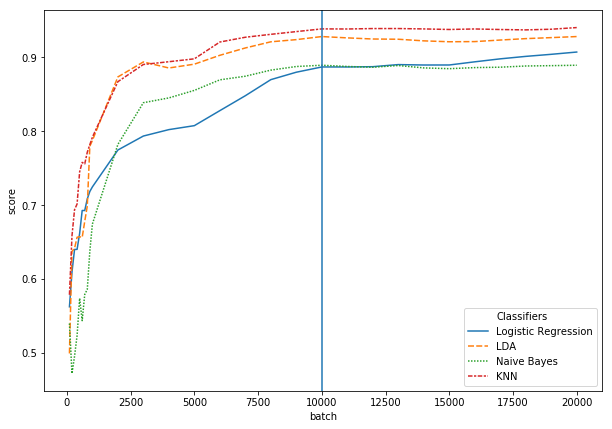

In [16]:
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.lineplot(x = 'batch', y='score', style= "Classifiers", hue="Classifiers", data=results)
plt.axvline(10000)

Como observamos no gráfico acima, batchs com tamanho acima de 10.000 não resultam em ganhos de score significativos. 

Este comportamento se confirma quando analisamos o desvio padrão dos scores de batchs a partir de 10.000, os desvios são muito pequenos indicando que há pouca variação em torno da média. 

In [17]:
tst = results[results["batch"] >= 10000]
pd.DataFrame(tst.groupby(["Classifiers"])["score"].std())

,score
Classifiers,
KNN,0.000829
LDA,0.002495
Logistic Regression,0.007339
Naive Bayes,0.001597


Já para os batchs até 10.000 verificamos uma variação maior em relação a média

In [29]:
tst = results[results["batch"] < 10000]
pd.DataFrame(tst.groupby(["Classifiers"])["score"].std())

,score
Classifiers,
KNN,0.103919
LDA,0.128643
Logistic Regression,0.090906
Naive Bayes,0.152803


### **2) Qual é o classificador que tem o melhor desempenho com poucos dados < 1000 exemplos.**

DESEMPENHO EM TERMOS DE SCORE
    
Em termos de score, o classificador com maior performance foi o KNN que classificou corretamente 78% do conjunto de testes. Contudo o classificador LDA também realizou um bom trabalho classificando corretamente 77% por dos dígitos. Os resultados podem ser verificados no gráfico abaixo


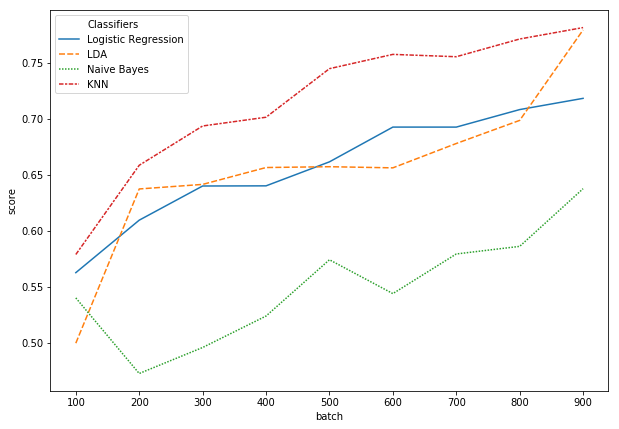

In [31]:
dt = results[results["batch"] < 1000]
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.lineplot(x = 'batch', y='score', style= "Classifiers", hue="Classifiers", data=dt)

In [34]:
pd.DataFrame(dt.groupby("Classifiers")["score"].max())

,score
Classifiers,
KNN,0.781707
LDA,0.779610
Logistic Regression,0.718412
Naive Bayes,0.637605


    **DESEMPENHO EM TERMOS DE TEMPO BASES < 1000** 

,time
Classifiers,
KNN,14.074135
LDA,0.149599
Logistic Regression,0.160016
Naive Bayes,2.236694


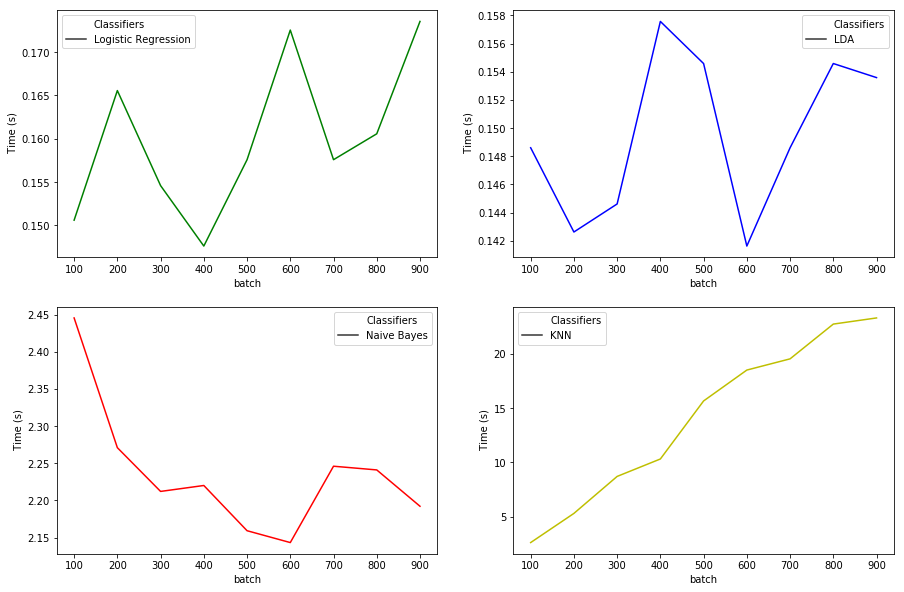

In [102]:
display(pd.DataFrame(dt.groupby("Classifiers")["time"].mean()))
fig, axes = plt.subplots(ncols=2, nrows=2, figsize = (15, 10))
colors = ['g', 'b', 'r', 'y']
clix = 0
for ix in range(2):
    for iy in range(2):
        clf = list(classifiers.keys())[clix]
        ax = axes[ix, iy]
        sns.lineplot(x = 'batch', y='time', style= "Classifiers", color=colors[clix], \
                     data=dt[dt["Classifiers"] == clf], ax = ax)
        ax.set(ylabel=" Time (s)")
        clix += 1

Para os batchs menores que 1000 observações o KNN apresenta um tempo constante e crescente acompanhando o crescimento de número de observações, isso se dá pela natureza do próprio algoritmo que faz uma varredura em todo o conjunto de teste para encontrar as menores distâncias do ponto observado. 
No tempo médio de execução de cada algoritmo para cada conjunto de treinamento menores que 1000 observação, o LDA apresentou melhor performance com 0.149 segundos seguido da regressão logística que executou num tempo médio de .16 segundos. 

### **3) Qual é o classificador que tem melhor desempenho com todos os dados.**



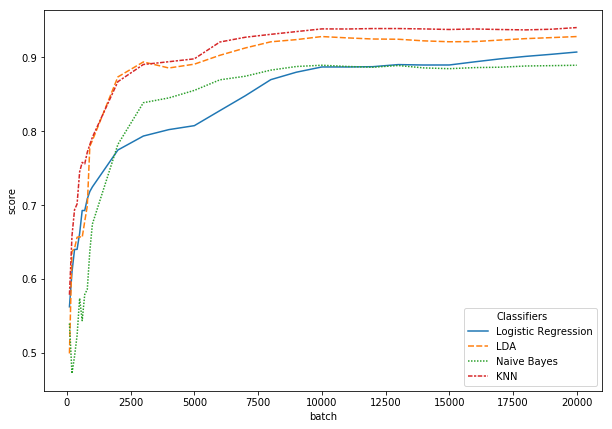

In [103]:
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.lineplot(x = 'batch', y='score', style= "Classifiers", hue="Classifiers", data=results)

In [ ]:
    4) Qual é o classificador é mais rápido para classificar os 58k exemplos de teste.